# Logistic Regression

In [98]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
from sklearn.metrics import classification_report, confusion_matrix

In [99]:
def hyperparam_sweep(x_train, y_train):
    param_grid = [
        {'solver': ['liblinear', 'saga'], 'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 10), 'max_iter': [100, 200, 300]},
        {'solver': ['newton-cg', 'lbfgs', 'sag'], 'penalty': ['l2'], 'C': np.logspace(-4, 4, 10), 'max_iter': [100, 200, 300]},
        {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': np.logspace(-4, 4, 10), 'max_iter': [100, 200, 300], 'l1_ratio': np.linspace(0, 1, 10)},
        {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'penalty': ['none'], 'max_iter': [100, 200, 300]}
    ]

    logreg = LogisticRegression()
    grid_search = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)
        
    # Suppress warnings for convergence, fit failed or invalid solver for current algorithm
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=FitFailedWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        
        grid_search.fit(x_train, y_train)
        
    return grid_search.best_params_

In [100]:
def fit_and_predict(hyperparams, x_train, x_test, y_train, y_test):
    logreg = LogisticRegression(**hyperparams)
    logreg.fit(x_train, y_train)
    
    y_pred = logreg.predict(x_test)

    return classification_report(y_test, y_pred, output_dict=True), classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred).ravel() 

In [101]:
def plot_confusion_matrix(matrix, cmap):
    tp, fp, fn, tn = matrix

    plt.figure(figsize=(8, 8))
    plt.imshow([[tp, fp], [fn, tn]], interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    plt.xticks([0, 1], ['Predicted Positive', 'Predicted Negative'])
    plt.yticks([0, 1], ['Actual Positive', 'Actual Negative'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.text(0, 0, tp, ha='center', va='center', color='white')
    plt.text(1, 0, fp, ha='center', va='center', color='black')
    plt.text(0, 1, fn, ha='center', va='center', color='black')
    plt.text(1, 1, tn, ha='center', va='center', color='white')

    plt.show()

In [102]:
def print_avg_metrics(full_metrics):
    accuracy = np.mean([metric['accuracy'] for metric in full_metrics])
    precision = np.mean([metric['macro avg']['precision'] for metric in full_metrics])
    recall = np.mean([metric['macro avg']['recall'] for metric in full_metrics])
    f1_score = np.mean([metric['macro avg']['f1-score'] for metric in full_metrics])
    
    print("- Accuracy: {:.3f}".format(accuracy))
    print("- Precision: {:.3f}".format(precision))
    print("- Recall: {:.3f}".format(recall))
    print("- F1-Score: {:.3f}".format(f1_score))

## Wine Quality Dataset

In [103]:
# Preprocess dataset
wineDF = pd.read_csv("./data/winequality-red.csv")

wineDF['label'] = wineDF['quality'].apply(lambda x: 'good' if x > 6 else 'bad')
wineDF.drop('quality', axis=1)

wine_y = wineDF['label'].values
wine_x = wineDF.drop('label', axis=1).values

In [104]:
# Standardize dataset
scaler = StandardScaler()
wine_x = scaler.fit_transform(wine_x)

Split 1:
              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       277
        good       1.00      1.00      1.00        43

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320


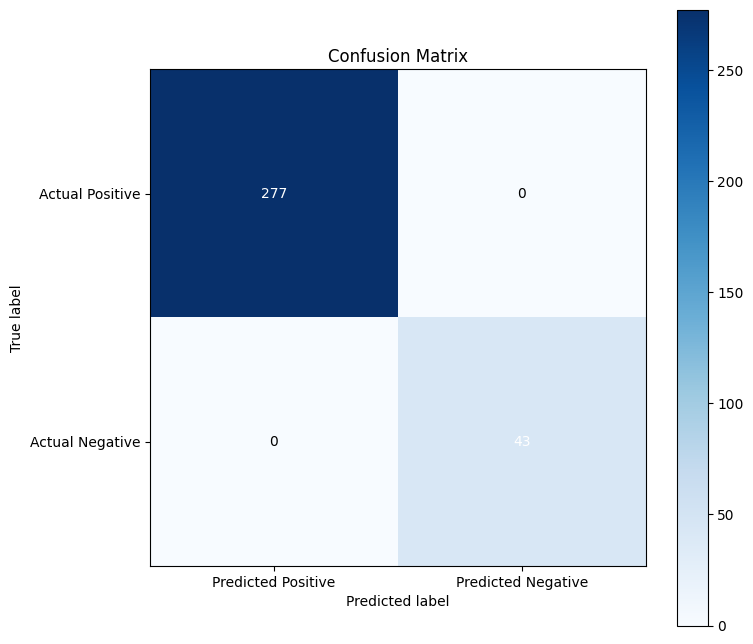

Split 2:
              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       277
        good       1.00      1.00      1.00        43

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320


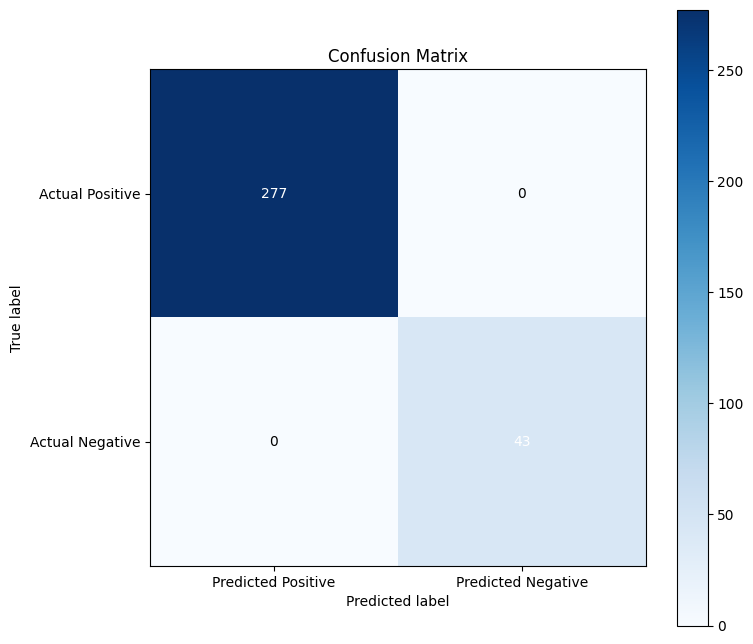

Split 3:
              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       277
        good       1.00      1.00      1.00        43

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320


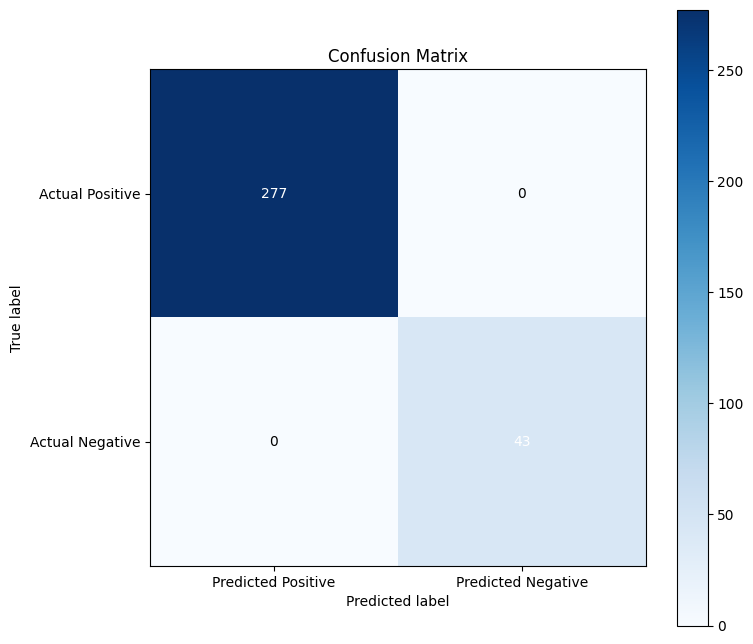

Split 4:
              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       277
        good       1.00      1.00      1.00        43

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320


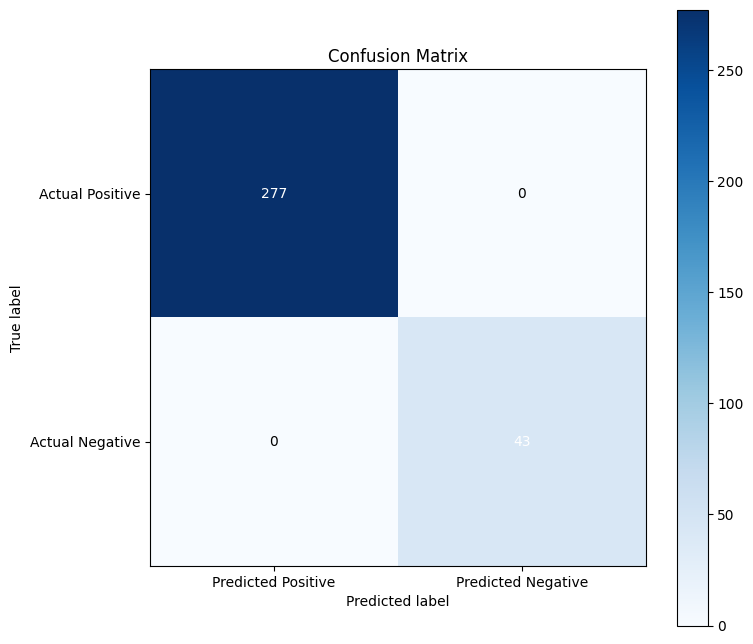

Split 5:
              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       277
        good       1.00      1.00      1.00        43

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320


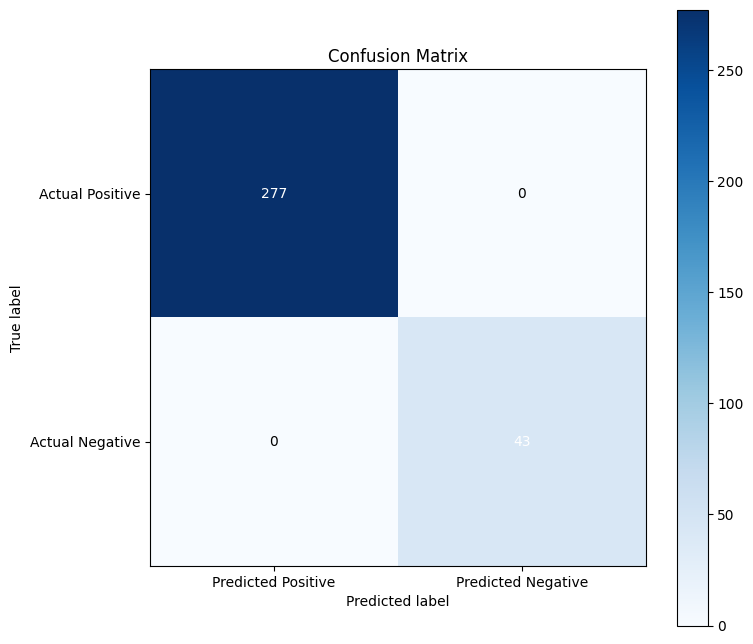

Average metrics:
- Accuracy: 1.000
- Precision: 1.000
- Recall: 1.000
- F1-Score: 1.000


In [105]:
# Cross validate
all_metrics = []

for i in range(5):
    print(f"Split {i+1}:")
    
    x_train, x_test, y_train, y_test = train_test_split(wine_x, wine_y, test_size=0.2, stratify=wine_y)
    
    best_params = hyperparam_sweep(x_train, y_train)
    
    metrics, report, cm = fit_and_predict(best_params, x_train, x_test, y_train, y_test)
    
    all_metrics.append(metrics)
    print(report)
    plot_confusion_matrix(cm, plt.cm.Blues)
    
print("Average metrics:")
print_avg_metrics(all_metrics)

## Heart Disease Dataset

In [106]:
# Preprocess dataset
heartDF = pd.read_csv("./data/heart_statlog_cleveland_hungary_final.csv")

heartDF['target'] = heartDF['target'].apply(lambda x: 'heart disease' if x else 'normal')
heart_y = heartDF['target'].values
heart_x = heartDF.drop('target', axis=1).values

In [107]:
# Standardize dataset
scaler = StandardScaler()
heart_x = scaler.fit_transform(heart_x)

Split 1:
               precision    recall  f1-score   support

heart disease       0.84      0.85      0.85       126
       normal       0.83      0.82      0.83       112

     accuracy                           0.84       238
    macro avg       0.84      0.84      0.84       238
 weighted avg       0.84      0.84      0.84       238


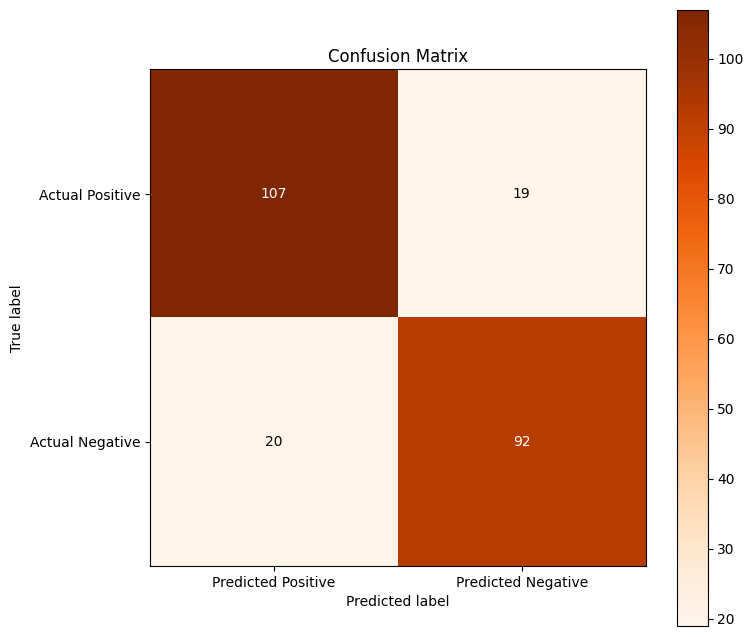

Split 2:
               precision    recall  f1-score   support

heart disease       0.86      0.88      0.87       126
       normal       0.86      0.84      0.85       112

     accuracy                           0.86       238
    macro avg       0.86      0.86      0.86       238
 weighted avg       0.86      0.86      0.86       238


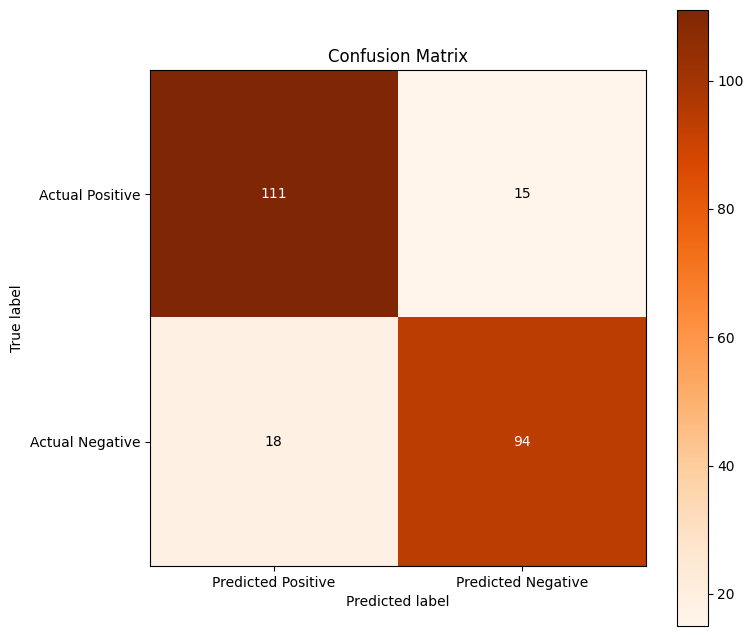

Split 3:
               precision    recall  f1-score   support

heart disease       0.82      0.84      0.83       126
       normal       0.82      0.79      0.81       112

     accuracy                           0.82       238
    macro avg       0.82      0.82      0.82       238
 weighted avg       0.82      0.82      0.82       238


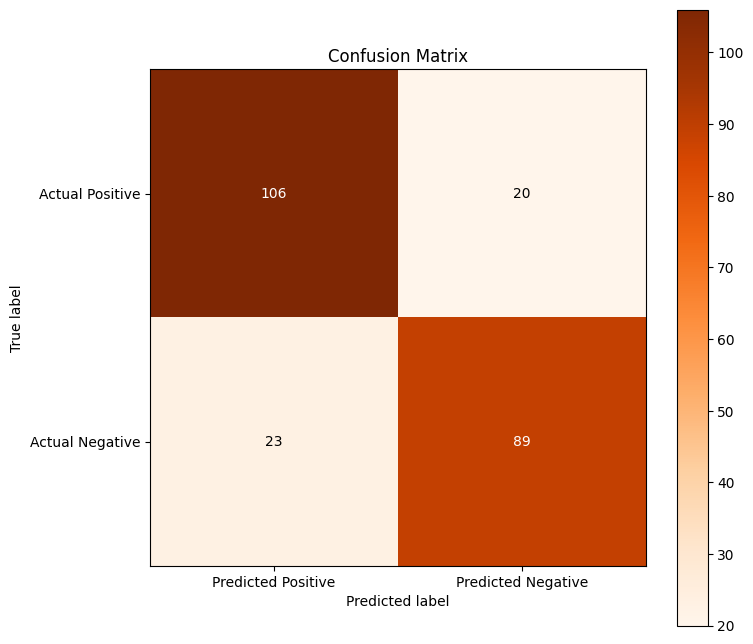

Split 4:
               precision    recall  f1-score   support

heart disease       0.82      0.88      0.85       126
       normal       0.85      0.79      0.82       112

     accuracy                           0.84       238
    macro avg       0.84      0.83      0.83       238
 weighted avg       0.84      0.84      0.84       238


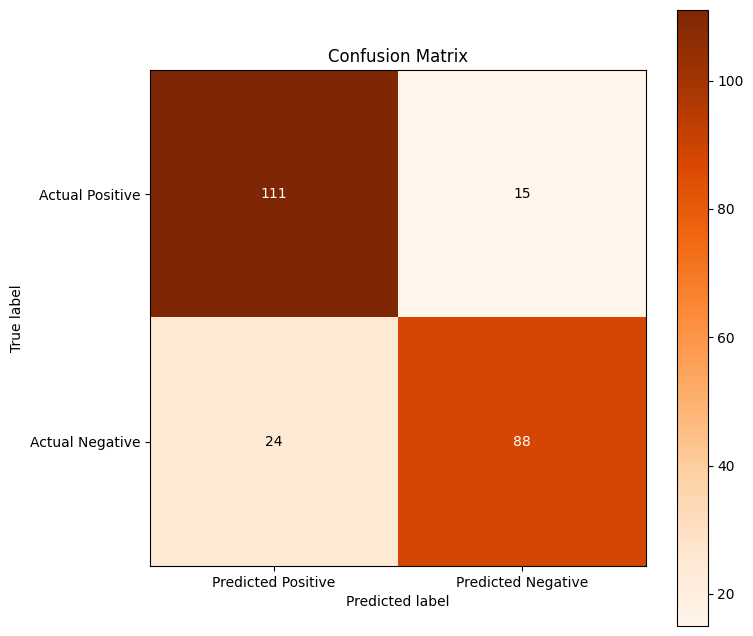

Split 5:
               precision    recall  f1-score   support

heart disease       0.84      0.86      0.85       126
       normal       0.84      0.82      0.83       112

     accuracy                           0.84       238
    macro avg       0.84      0.84      0.84       238
 weighted avg       0.84      0.84      0.84       238


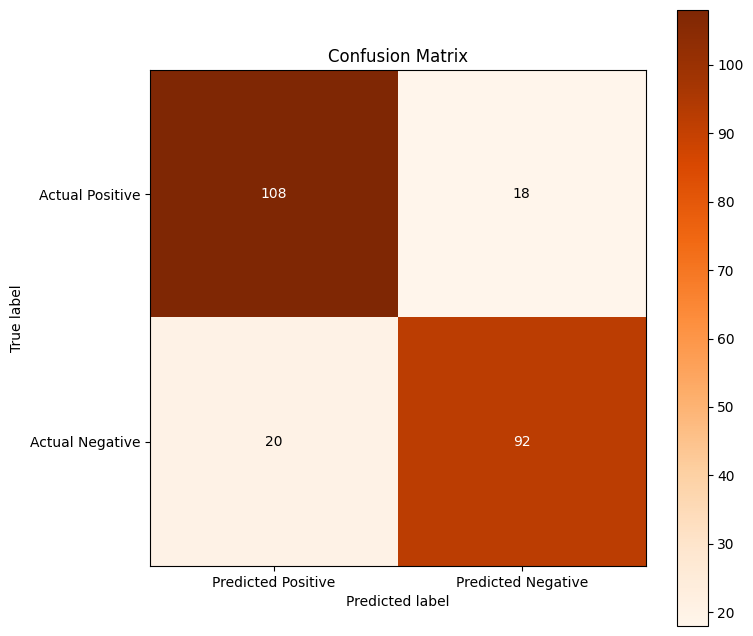

- Accuracy: 0.839
- Precision: 0.839
- Recall: 0.837
- F1-Score: 0.838


In [108]:
# Cross validate
all_metrics = []

for i in range(5):
    print(f"Split {i+1}:")
    
    x_train, x_test, y_train, y_test = train_test_split(heart_x, heart_y, test_size=0.2, stratify=heart_y)
    
    best_params = hyperparam_sweep(x_train, y_train)
    
    metrics, report, cm = fit_and_predict(best_params, x_train, x_test, y_train, y_test)
    
    all_metrics.append(metrics)
    print(report)
    plot_confusion_matrix(cm, plt.cm.Oranges)
    
print("Average metrics:")
print_avg_metrics(all_metrics)